<IMG SRC="https://raw.githubusercontent.com/pastas/pastas/master/doc/_static/logo.png" WIDTH=250 ALIGN="right">

# Example 1: Pastas Cookbook recipe
***

This notebook is supplementary material to the following paper submitted to Groundwater:

*R.A. Collenteur, M. Bakker, R. Calje, S. Klop, F. Schaars, (2019) Pastas: open source software for the analysis of groundwater time series, Manuscript under review.*

In this notebook the Pastas "cookbook" recipe is shown. In this example it is investigated how well the heads measured in a borehole near Kingstown, Rhode Island, US, can be simulated using rainfall and potential evaporation. A transfer function noise (TFN) model using impulse response function is created to simulate the observed heads.

The observed heads are obtained from the Ground-Water Climate Response Network (CRN) of the USGS (https://groundwaterwatch.usgs.gov/). The corresponding USGS site id is 412918071321001. The rainfall data is taken from the Global Summary of the Day dataset (GSOD) available at the National Climatic Data Center (NCDC). The rainfall series is obtained from the weather station in Kingston (station number: NCDC WBAN 54796) located at  41.491$^\circ$, -71.541$^\circ$. The evaporation is calculated from the mean temperature obtained from the same USGS station using Thornthwaite's method (Pereira and Pruitt, 2004).

*Pereira AR, Pruitt WO (2004),  Adaptation of the Thornthwaite scheme for estimating daily reference evapotranspiration, Agricultural Water Management 66(3), 251-257*

### Step 1. Importing the python packages
The first step to creating the TFN model is to import the python packages. In this notebook two packages are used, the Pastas package and the Pandas package to import the time series data. Both packages are short aliases for convenience (`ps` for the Pastas package and `pd` for the Pandas package). The other packages that are imported are not needed for the analysis but are needed to make the publication figures.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import pastas as ps
ps.set_log_level("ERROR")
%matplotlib inline

# This notebook has been developed using Pastas version 0.9.9 and Python 3.7
print("Pastas version: {}".format(ps.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("Python version: {}".format(os.sys.version))

Pastas version: 0.12.0b
Pandas version: 0.24.2
Numpy version: 1.15.4
Python version: 3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Step 2. Reading the time series
The next step is to import the time series data. Three series are used in this example; the observed groundwater head, the rainfall and the evaporation. The data can be read using different methods, in this case the Pandas `read_csv` method is used to read the csv files. Each file consists of two columns; a date column called 'Date' and a column containing the values for the time series. The index column is the first column and is read as a date format. The heads series are stored in the variable `obs`, the rainfall in `rain` and the evaporation in `evap`. All variables are transformed to SI-units.

In [2]:
obs = pd.read_csv('obs.csv', index_col='Date', parse_dates=True) * 0.3048
rain = pd.read_csv('rain.csv', index_col='Date', parse_dates=True) * 0.3048
rain = rain.asfreq("D", fill_value=0.0) # There are some nan-values present
evap = pd.read_csv('evap.csv', index_col='Date', parse_dates=True) * 0.3048

### Step 3. Creating the model
After reading in the time series, a Pastas Model instance can be created, `Model`. The `Model` instance is stored in the variable `ml` and takes two input arguments; the head time series `obs`, and a model name: "Kingstown".

In [3]:
ml = ps.Model(obs.loc[::14], name='Kingstown')

### Step 4. Adding stress models
A `RechargeModel` instance is created and stored in the variable `rm`, taking the rainfall and potential evaporation time series as input arguments, as well as a name and a response function. In this example the Gamma response function is used (the Gamma function is available as `ps.Gamma`). After creation the recharge stress model instance is added to the model. 

In [4]:
rm = ps.RechargeModel(rain, evap, name='recharge', rfunc=ps.Gamma)
ml.add_stressmodel(rm)

### Step 5. Solving the model
The model parameters are estimated by calling the `solve` method of the `Model` instance. In this case the default settings are used (for all but the tmax argument) to solve the model. Several options can be specified in the `.solve` method, for example; a `tmin` and `tmax` or the type of solver used (this defaults to a least squares solver, `ps.LeastSquares`). This `solve` method prints a fit report with basic information about the model setup and the results of the model fit.

In [5]:
ml.solve(tmax="2014");

# Print some information on the model fit for the validation period
print("\nThe R2 and the RMSE in the validation period are ", ml.stats.rsq(tmin="2015", tmax="2019").round(2), 
      "and", ml.stats.rmse(tmin="2015", tmax="2019").round(2), ", respectively.")

Model Results Kingstown           Fit Statistics
nfev     27                     EVP        89.19
nobs     281                    R2          0.89
noise    1                      RMSE        0.12
tmin     2003-01-01 00:00:00    AIC        11.73
tmax     2014-01-01 00:00:00    BIC        33.57
freq     D                      ___             
warmup   3650                   ___             
solver   LeastSquares           ___             

Parameters (6 were optimized)
                optimal   stderr    initial vary
recharge_A   336.550870   ±5.60%  98.181587    1
recharge_n     1.294862   ±1.80%   1.000000    1
recharge_a    61.327400   ±6.36%  10.000000    1
recharge_f    -0.676914   ±7.67%  -1.000000    1
constant_d    -4.431278   ±1.52%  -3.578965    1
noise_alpha   75.226546  ±18.02%  14.000000    1

The R2 and the RMSE in the validation period are  0.84 and 0.13 , respectively.


### Step 6. Visualizing the results
The final step of the "cookbook" recipe is to visualize the results of the TFN model. The Pastas package has several build in plotting methods, available through the `ml.plots` instance. Here the `.results` plotting method is used. This method plots an overview of the model results, including the simulation and the observations of the groundwater head, the optimized model parameters, the residuals and the noise, the contribution of each stressmodel, and the step response function for each stressmodel. 

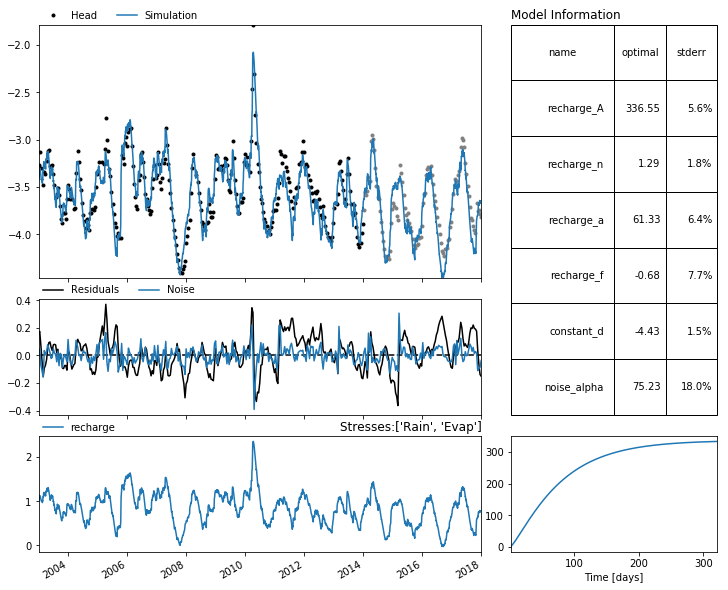

In [6]:
ml.plots.results(tmax="2018");

### 7. Diagnosing the noise series
The `diagnostics` plot can be used to interpret how well the noise follows a normal distribution and suffers from autocorrelation (or not).

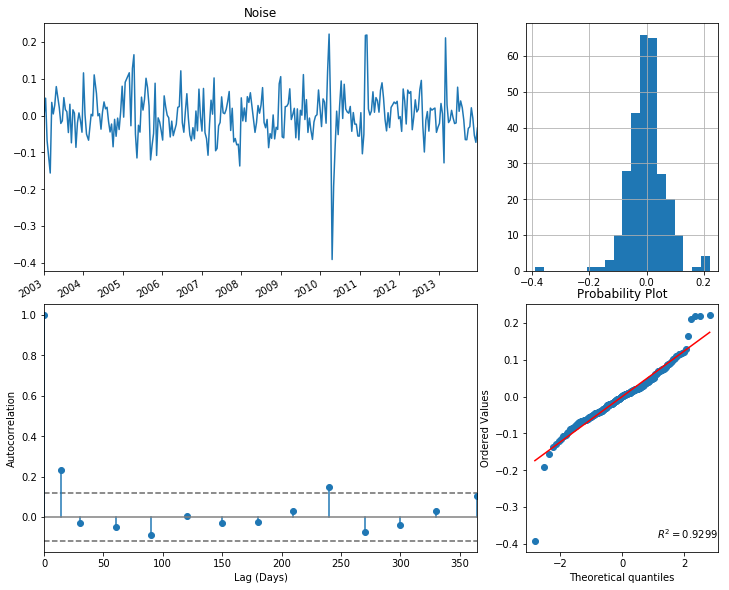

In [7]:
ml.plots.diagnostics()

# Make plots for publication
In the next codeblocks the Figures used in the Pastas paper are created. The first codeblock sets the matplotlib parameters to obtain publication-quality figures. The following figures are created:

- Figure of the impulse and step respons for the scaled Gamma response function
- Figure of the stresses used in the model
- Figure of the modelfit and the step response
- Figure of the model fit as returned by Pastas
- Figure of the model residuals and noise
- Figure of the Autocorrelation function

In [8]:
# Set matplotlib params to create publication figures
params = {
   'axes.labelsize': 18,
   'axes.grid': True,
   'font.size': 16,
   'font.family': 'serif',
   'legend.fontsize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False,
   'figure.figsize': [8.2, 5],
   'lines.linewidth' : 2
   }
plt.rcParams.update(params)

# Save figures or not
savefig = True
figpath = "figures"
if not os.path.exists(figpath):
    os.mkdir(figpath)

### Make a plot of the impulse and step response for the Gamma and Hantush functions

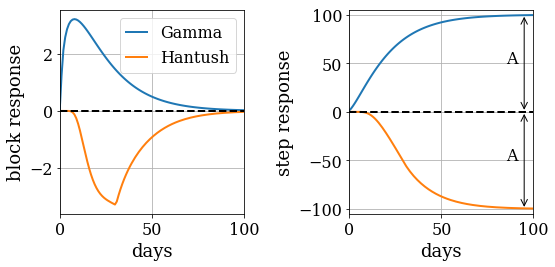

In [9]:
rfunc = ps.Gamma(cutoff=0.999)
p = [100, 1.5, 15]
b = np.append(0, rfunc.block(p))
s = rfunc.step(p)

rfunc2 = ps.Hantush(cutoff=0.999)
p2 = [-100, 4, 15]
b2 = np.append(0, rfunc2.block(p2))
s2 = rfunc2.step(p2)

# Make a figure of the step and block response
fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
ax1.plot(b)
ax1.plot(b2)
ax1.set_ylabel("block response")
ax1.set_xlabel("days")
ax1.legend(["Gamma", "Hantush"], handlelength=1.3)
ax1.axhline(0.0, linestyle="--", c="k")

ax2.plot(s)
ax2.plot(s2)
ax2.set_xlim(0,100)
ax2.set_ylim(-105, 105)
ax2.set_ylabel("step response")
ax2.set_xlabel("days")
ax2.axhline(0.0, linestyle="--", c="k")
ax2.annotate('', xy=(95, 100), xytext=(95, 0),
             arrowprops={'arrowstyle': '<->'})
ax2.annotate('A', xy=(95, 100), xytext=(85, 50))
ax2.annotate('', xy=(95, -100), xytext=(95, 0),
             arrowprops={'arrowstyle': '<->'})
ax2.annotate('A', xy=(95, 100), xytext=(85, -50))
plt.tight_layout()

if savefig:
    path = os.path.join(figpath, "impuls_step_response.eps")
    plt.savefig(path, dpi=300, bbox_inches="tight")

### Make a plot of the stresses used in the model

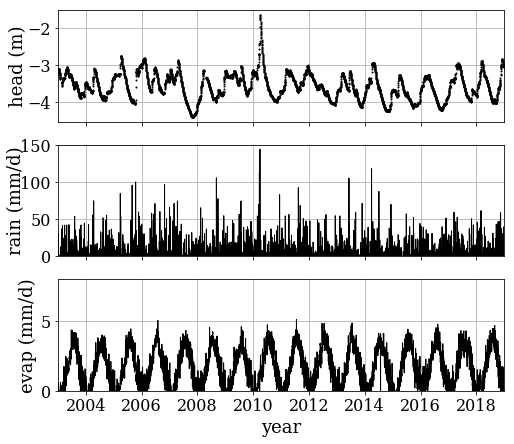

In [10]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1, sharex=True, figsize=(8, 7))

ax1.plot(obs, 'k.',label='obs', markersize=2)
ax1.set_ylabel('head (m)', labelpad=0)
ax1.set_yticks([-4, -3, -2])

plot_rain = ax2.plot(rain * 1000, color='k', label='prec', linewidth=1)
ax2.set_ylabel('rain (mm/d)', labelpad=-5)
ax2.set_xlabel('Date');
ax2.set_ylim([0,150])
ax2.set_yticks(np.arange(0, 151, 50))

plot_evap = ax3.plot(evap * 1000,'k', label='evap', linewidth=1)
ax3.set_ylabel('evap (mm/d)')
ax3.tick_params('y')
ax3.set_ylim([0,8])

plt.xlim(['2003','2019'])
plt.xticks([str(x) for x in np.arange(2004, 2019, 2)], rotation=0, horizontalalignment='center')
ax2.set_xlabel("")
ax3.set_xlabel("year")

if savefig:
    path = os.path.join(figpath, "data_example_1.eps")
    plt.savefig(path, bbox_inches='tight', dpi=300)

### Make a custom figure of the model fit and the estimated step response

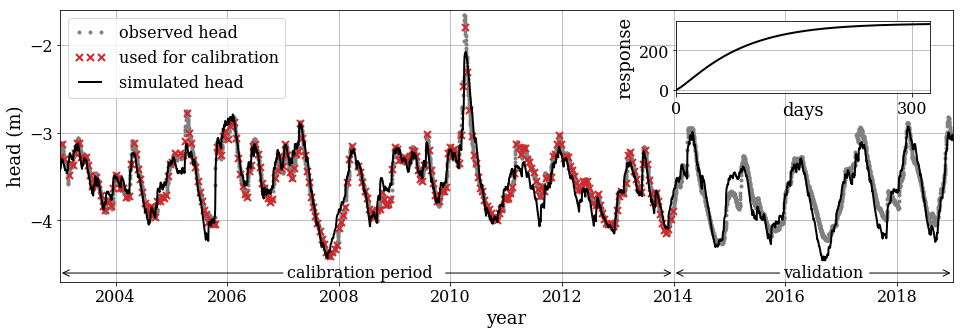

In [11]:
# Create the main plot
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(obs, marker=".", c="grey", linestyle=" ")
ax.plot(obs.loc[:"2013":14], marker="x", markersize=7, c="C3", linestyle=" ", mew=2)
ax.plot(ml.simulate(tmax="2019"), c="k")
plt.ylabel('head (m)')
plt.xlabel('year')
plt.title("")
plt.xticks([str(x) for x in np.arange(2004, 2019, 2)], rotation=0, horizontalalignment='center')
plt.xlim('2003', '2019')
plt.ylim(-4.7, -1.6)
plt.yticks(np.arange(-4, -1, 1))

# Create the arrows indicating the calibration and validation period
ax.annotate("calibration period", xy=("2003-01-01", -4.6), xycoords='data',
            xytext=(300, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")
ax.annotate("", xy=("2014-01-01", -4.6), xycoords='data',
            xytext=(-230, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")

ax.annotate("validation", xy=("2014-01-01", -4.6), xycoords='data',
            xytext=(150, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")
ax.annotate("", xy=("2019-01-01", -4.6), xycoords='data',
            xytext=(-85, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")

plt.legend(["observed head", "used for calibration","simulated head"], loc=2, numpoints=3)

# Create the inset plot with the step response
ax2 = plt.axes([0.66, 0.65, 0.22, 0.2])
s = ml.get_step_response("recharge")
ax2.plot(s, c="k")
ax2.set_ylabel("response")
ax2.set_xlabel("days", labelpad=-15)
ax2.set_xlim(0, s.index.size)
ax2.set_xticks([0, 300])

if savefig:
    path = os.path.join(figpath, "results.eps")
    plt.savefig(path, bbox_inches='tight', dpi=300)

### Make a figure of the fit report

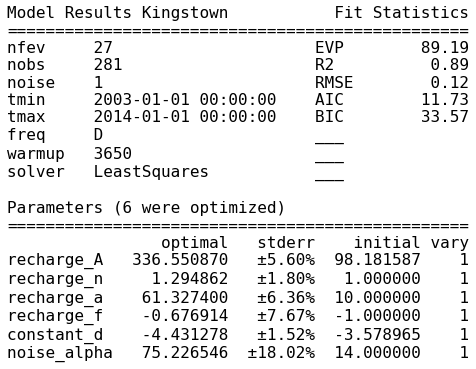

In [12]:
plt.text(-1, -1, str(ml.fit_report()), {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()

if savefig:
    path = os.path.join(figpath, "fit_report.eps")
    plt.savefig(path, bbox_inches='tight', dpi=300)

### Make a Figure of the noise, residuals and autocorrelation

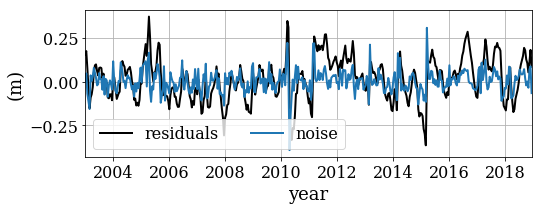

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 3))
ml.residuals(tmax="2019").plot(ax=ax1, c="k")
ml.noise(tmax="2019").plot(ax=ax1, c="C0")
plt.xticks([str(x) for x in np.arange(2004, 2019, 2)], rotation=0, horizontalalignment='center')
ax1.set_ylabel('(m)')
ax1.set_xlabel('year')
ax1.legend(["residuals", "noise"], ncol=2)

if savefig:
    path = os.path.join(figpath, "residuals.eps")
    plt.savefig(path, bbox_inches='tight', dpi=300)

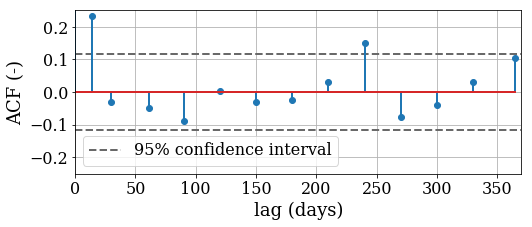

In [14]:
fig, ax2 = plt.subplots(1,1, figsize=(8, 3))
n =ml.noise()
conf = 1.96 / np.sqrt(n.index.size)
acf = ps.stats.acf(n)
ax2.axhline(conf, linestyle='--', color="dimgray")
ax2.axhline(-conf, linestyle='--', color="dimgray")
ax2.stem(acf.index, acf.values)
ax2.set_ylabel('ACF (-)')
ax2.set_xlabel('lag (days)')
plt.xlim(0, 370)
plt.ylim(-0.25, 0.25)
plt.legend(["95% confidence interval"])

if savefig:
    path = os.path.join(figpath, "acf.eps")
    plt.savefig(path, bbox_inches='tight', dpi=300)

In [15]:
h, test = ps.stats.ljung_box(ml.noise())
print("The hypothesis that there is significant autocorrelation is:", h)
test

The hypothesis that there is significant autocorrelation is: False


,LBtest,P-value,Accept Ha (alpha=0.05)
Lags (Days),,,
14.0,-10.712254,1.0,False
30.0,-10.722531,1.0,False
61.0,-10.731830,1.0,False
90.0,-10.751429,1.0,False
120.0,-10.751453,1.0,False
150.0,-10.752816,1.0,False
180.0,-10.753598,1.0,False
210.0,-10.754539,1.0,False
240.0,-10.773580,1.0,False
